In [2]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [3]:
class KeyboardKey:
    def __init__(self, main_char, shift_char):
        self.main_char = main_char
        self.shift_char = shift_char

    def __repr__(self):
        return f"KeyboardKey(main='{self.main_char}', shift='{self.shift_char}')"

In [4]:
# Define the keys for each row
rows = [
    [KeyboardKey('1', '!'), KeyboardKey('2', '@'), KeyboardKey('3', '#'), KeyboardKey('4', '$'),
     KeyboardKey('5', '%'), KeyboardKey('6', '^'), KeyboardKey('7', '&'), KeyboardKey('8', '*'),
     KeyboardKey('9', '('), KeyboardKey('0', ')'), KeyboardKey('-', '_'), KeyboardKey('=', '+')],
    
    [KeyboardKey('Q', 'Q'), KeyboardKey('W', 'W'), KeyboardKey('E', 'E'), KeyboardKey('R', 'R'),
     KeyboardKey('T', 'T'), KeyboardKey('Y', 'Y'), KeyboardKey('U', 'U'), KeyboardKey('I', 'I'),
     KeyboardKey('O', 'O'), KeyboardKey('P', 'P'), KeyboardKey('[', '{'), KeyboardKey(']', '}'),
     KeyboardKey('\\', '|')],
    
    [KeyboardKey('A', 'A'), KeyboardKey('S', 'S'), KeyboardKey('D', 'D'), KeyboardKey('F', 'F'),
     KeyboardKey('G', 'G'), KeyboardKey('H', 'H'), KeyboardKey('J', 'J'), KeyboardKey('K', 'K'),
     KeyboardKey('L', 'L'), KeyboardKey(';', ':'), KeyboardKey('\'', '"')],
    
    [KeyboardKey('Z', 'Z'), KeyboardKey('X', 'X'), KeyboardKey('C', 'C'), KeyboardKey('V', 'V'),
     KeyboardKey('B', 'B'), KeyboardKey('N', 'N'), KeyboardKey('M', 'M'), KeyboardKey(',', '<'),
     KeyboardKey('.', '>'), KeyboardKey('/', '?')]
]

In [5]:
def draw_keyboard(frame, alpha=0.5, shift=False):
    overlay = frame.copy()
    origin_x, origin_y = 200, 150
    key_width, key_height = 70, 70
    padding = 10
    key_positions = []  # Store key positions for collision detection
    key_color = (0, 0, 200)
    solid_text_color = (255, 255, 255)  # Solid white
    shaded_text_color = (160, 160, 160)  # Shaded white for alpha effect

    for i, row in enumerate(rows):
        x = origin_x
        for key in row:
            top_left = (x, origin_y + i * (key_height + padding))
            bottom_right = (x + key_width, origin_y + i * (key_height + padding) + key_height)
            key_positions.append((key.main_char, key.shift_char, top_left, bottom_right))
            cv2.rectangle(overlay, top_left, bottom_right, key_color, -1)
            cv2.rectangle(overlay, top_left, bottom_right, solid_text_color, 2)

            if shift:
                main_color = shaded_text_color
                shift_color = solid_text_color
            else:
                main_color = solid_text_color
                shift_color = shaded_text_color

            # Draw the main character
            cv2.putText(overlay, key.main_char, (x + 15, origin_y + i * (key_height + padding) + int(key_height/2) + 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, main_color, 1, cv2.LINE_AA)
            
            # Draw the shift character in the top right corner
            cv2.putText(overlay, key.shift_char, (x + key_width - 20, origin_y + i * (key_height + padding) + 15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, shift_color, 1, cv2.LINE_AA)
            
            x += key_width + padding

    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
    return key_positions

In [6]:
BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
GestureRecognizerResult = mp.tasks.vision.GestureRecognizerResult
VisionRunningMode = mp.tasks.vision.RunningMode
# Create a gesture recognizer instance with the live stream mode:
recognized_gesture = ""
landmarks = []
def print_result(result: GestureRecognizerResult, output_image: mp.Image, timestamp_ms: int):
    global recognized_gesture
    global landmarks
    #print(result)
    if result.gestures:
        #print("Gestures detected:")
        # Take the gesture with the highest confidence
        recognized_gesture = ""
        for gesture in result.gestures:
            #print(f"Gesture: {gesture[0].category_name} ({gesture[0].score:.2f})")
            # Append each gesture to the recognized_gesture variable
            recognized_gesture += f"{gesture[0].category_name} ({gesture[0].score:.2f}), "
    else:
        recognized_gesture = "NOT FOUND"
    if result.hand_landmarks:
        landmarks = result.hand_landmarks
    #if result.hand_landmarks:
    #    hand_landmarks = result.hand_landmarks[0].landmark  # Take the first hand detected
    #else:
    #    hand_landmarks = []
    #print('gesture recognition result: {}'.format(result))


options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='C:\\Users\\User\\Desktop\\Universita\\Magistrale\\GeReco\\gesture_recognizer.task'),
    running_mode=VisionRunningMode.LIVE_STREAM,
    num_hands=2,
    result_callback=print_result)

# Initialize MediaPipe and OpenCV
mp_image = mp.Image
mp_image_format = mp.ImageFormat

In [28]:
import time

TIME_THRESHOLD = 2
key_timer = None
stored_key = None

def is_finger_over_key(finger_x, finger_y, key_positions, shift=False):
    global key_timer, stored_key
    for key, shifted_key, top_left, bottom_right in key_positions:
        if top_left[0] <= finger_x <= bottom_right[0] and top_left[1] <= finger_y <= bottom_right[1]:
            if key_timer is None:  
                key_timer = time.time()
                stored_key = key
                print(f"Start timer for key: {shifted_key if shift else key}, start_time: {key_timer}")
            elif time.time() - key_timer >= TIME_THRESHOLD:
                if stored_key != key:
                    key_timer = time.time()  
                    stored_key = key
                else:
                    print(f"Finger over key: {shifted_key if shift else key}")
                    key_timer = None  
                    stored_key = None  
                    return key, shifted_key, finger_x, finger_y
            if stored_key != key:
                key_timer = time.time()  
                stored_key = key
    return None


    

In [24]:
finger_postions_x = []
finger_postions_y = []

In [29]:
INDEX_TIP = 8

cap = cv2.VideoCapture(0)
shifted = False
can_be_shifted = True
store_trajectory = False

current_word=""


if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
# Set the desired resolution
frame_width = 1280  # Width in pixels
frame_height = 720  # Height in pixels
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)
# Initialize the MediaPipe Hands module

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    with GestureRecognizer.create_from_options(options) as recognizer:
        
        start_time = time.time()  # Tempo di riferimento iniziale
        # Convert the frame (OpenCV image) to MediaPipe's Image object
        numpy_frame_from_opencv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mp_image_object = mp_image(image_format=mp_image_format.SRGB, data=numpy_frame_from_opencv)


        frame_timestamp_ms = int((time.time() - start_time) * 1000)

        recognizer.recognize_async(mp_image_object, timestamp_ms=frame_timestamp_ms)

                # Overlay the recognized gesture on the frame
        cv2.putText(frame, f"Gesture: {recognized_gesture}", (10, 700), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                # Draw hand landmarks on the frame

        if landmarks:
            for it, hand in enumerate(landmarks):
                cv2.putText(frame, f"Index Tip Position Y: {landmarks[it][INDEX_TIP].y * frame_height:.2f}, X: {landmarks[it][INDEX_TIP].x * frame_width:.2f}, Z: {landmarks[it][INDEX_TIP].z:.2f}", (10, 600 + it * 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                for landmark in hand:
                    #print(f"Landmark: {landmark.x}, {landmark.y}, {landmark.z}")
                    x = int(landmark.x * frame.shape[1])
                    y = int(landmark.y * frame.shape[0])
                    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
        
         # Draw connections
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
            (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
            (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
            (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
            (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
        ]
        
        for hand in landmarks:
            for start, end in connections:
                start_x = int(hand[start].x * frame.shape[1])
                start_y = int(hand[start].y * frame.shape[0])
                end_x = int(hand[end].x * frame.shape[1])
                end_y = int(hand[end].y * frame.shape[0])
                cv2.line(frame, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
    
        keyposition = draw_keyboard(frame, alpha=0.5, shift=shifted)
        if recognized_gesture:
            if ("index_up" in recognized_gesture):
                key_pressed = is_finger_over_key(landmarks[0][INDEX_TIP].x * frame_width, landmarks[0][INDEX_TIP].y * frame_height, keyposition, shift=shifted)
                if key_pressed is not None:
                    print("Start storing trajectory")
                    store_trajectory = True
                    current_word += key_pressed[0]
            if ("two" in recognized_gesture):
                if can_be_shifted:
                    print("Two gesture")
                    shifted = not shifted
                    can_be_shifted = False
            if ("fist" in recognized_gesture):
                store_trajectory = False
                print("Stop storing trajectory")
            if ("two" not in recognized_gesture):
                can_be_shifted = True
            
        
        if store_trajectory:
            finger_postions_x.append(landmarks[0][INDEX_TIP].x * frame_width)
            finger_postions_y.append(landmarks[0][INDEX_TIP].y * frame_height)
                
        cv2.putText(frame, f"Word: {current_word}", (10, frame_height - 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)
        
        cv2.imshow('Virtual Keyboard', frame)

        shortcut = cv2.waitKey(1)
        
        if shortcut == ord('q'):
            break
        elif shortcut == ord('c'):
            finger_postions_x = []
            finger_postions_y = []
            store_trajectory = False
            current_word = ""  
            print("Cleared trajectory")
    
cap.release()
cv2.destroyAllWindows()


Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Start timer for key: I, start_time: 1736960441.377034
Finger over key: I
Start storing trajectory
Start timer for key: I, start_time: 1736960443.6094482
Finger over key: O
Start storing trajectory
Start timer for key: O, start_time: 1736960446.8791778
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop storing trajectory
Stop

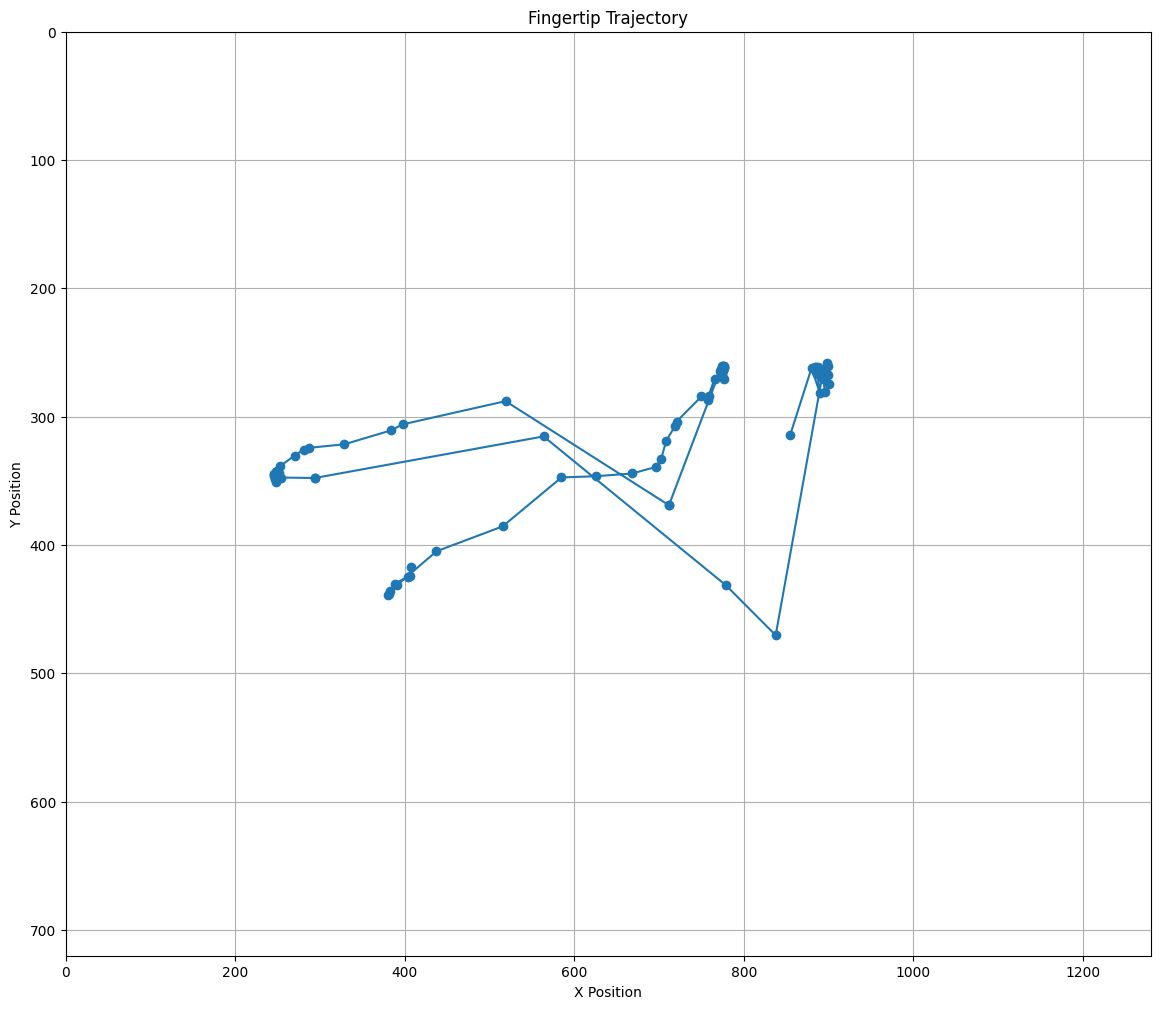

In [30]:
import matplotlib.pyplot as plt

def plot_trajectory(x_coords, y_coords):
    plt.figure(figsize=(14, 12))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    plt.title('Fingertip Trajectory')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.grid(True)
    plt.show()

plot_trajectory(finger_postions_x, finger_postions_y)

In [16]:
def is_point_in_rectangle(x, y, top_left, bottom_right):
    return top_left[0] <= x <= bottom_right[0] and top_left[1] <= y <= bottom_right[1]


In [17]:
def map_trajectory_to_keys(finger_positions_x, finger_positions_y, key_positions):
    pressed_keys = []  

    for x, y in zip(finger_positions_x, finger_positions_y):
        for main_char, shift_char, top_left, bottom_right in key_positions:
            if is_point_in_rectangle(x, y, top_left, bottom_right):
                pressed_keys.append(main_char)

    return pressed_keys

In [18]:
key_positions = draw_keyboard(frame)  
pressed_keys = map_trajectory_to_keys(finger_postions_x, finger_postions_y, key_positions)

print("Pressed keys:", pressed_keys)


Pressed keys: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'V', 'V', ',', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'M', '.', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', '.', 'R', 'R', 'R', 'R', 'T', 'Y', 'U', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'K', 'M', 'G', 'R', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'D', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'D', 'V', 'V', 'U', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
